In [ ]:
# Imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F
import random
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import torchvision
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import sys
sys.path.append("/home/sipl-prj10364/.local/lib/python3.11.9/site-packages")
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy.signal import butter, filtfilt
from tqdm import tqdm
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import scipy.io
from sklearn.metrics import confusion_matrix
from tempfile import TemporaryDirectory
import time
from sklearn.metrics import accuracy_score
import pytorch_lightning as pl
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import KernelPCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from matplotlib import animation
import torch, torch.nn.functional as F
import os

In [ ]:
# Defining classes
class Hyper_Params:
    def __init__(self, params_dict=None):
        if params_dict:
            self.params_dict = params_dict
        else:
            self.params_dict = {
    
                'i_break':None,
                'batch_size':None,
                'model_params':{},
                'train_transforms' : None,
                'test_transforms': None,
                'lines': None,
                'epochs': None,
                'lr':None,
                'momentum': None,
                'optimizer': None,
                'scheduler_step_size':None,
                'scheduler_gamma':None,
                'epoch_loss_train': [],
                'epoch_accuracy_train': [],
                'train_loss_record': [],
                'train_accuracy_record': [],
                'test_loss_record': [],
                'test_accuracy_record': [],
                'fig': None,
                'ax1': None,
                'ax2': None,
                'space': None,
                }
    def __getattr__(self, attr):
        if attr in self.params_dict:
            return self.params_dict[attr]
        else:
            raise AttributeError(f"'Params' object has no attribute '{attr}'")
        
    def __setattr__(self, attr, value):
        if attr == 'params_dict':
            super().__setattr__(attr, value)
        else:
            self.params_dict[attr] = value
    def __getitem__(self, key):
        return self.params_dict[key]

In [ ]:
class DAE(nn.Module):
    def __init__(self, in_channels=5, latent_dim=64):
        super(DAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, latent_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(latent_dim, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.ConvTranspose1d(16, in_channels, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [6]:
class LinearClassifier(nn.Module):
    def __init__(self, encoder_output_dim=64, num_classes=4):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(encoder_output_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(64, num_classes)
        )

    def forward(self, x, encoder):
        with torch.no_grad():
            x = encoder(x)  
        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)  
        return self.classifier(x)


In [7]:
# Filtering & Decimation
def butter_bandpass(lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=1):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, padlen=2)
    return -y

def filter_set(X):
    filtered_data = []
    for i in range(len(X)):
        filtered_X = butter_bandpass_filter(X[i], 30, 250, 1e3, order=5)
        data = filtered_X[::10]   
        filtered_data.append(data)
    return torch.Tensor(filtered_data)

In [ ]:
# Fourier transform
def fft(filtered_X):
    fft_complex = torch.fft.fft(filtered_X, dim=-1) 
    fft_abs = fft_complex.abs()
    return fft_abs

In [ ]:
# Plotting 3D function 
def plot_embeddings_3d_with_rotation(
    embeddings_3d, y, class_dict, graph_title,
    density_centroids=None, output_path="rotation.mp4",
    fps=20, duration=5, slowdown_factor=2
):
    classes = np.unique(y)
    colors = plt.cm.tab10.colors
    frames = fps * duration * slowdown_factor

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # plot points
    for i, cls in enumerate(classes):
        idx = (y == cls)
        ax.scatter(
            embeddings_3d[idx, 0],
            embeddings_3d[idx, 1],
            embeddings_3d[idx, 2],
            label=class_dict.get(cls, str(cls)),
            color=colors[i % len(colors)],
            s=5, alpha=0.7
        )

    if density_centroids:
        for cls, centroid in density_centroids.items():
            ax.scatter(*centroid, color='black', marker='X', s=100)

    ax.set_title(graph_title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.legend()
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)

    def update(frame):
        azim = 360 * (frame / frames)
        ax.view_init(elev=30, azim=azim)

    ani = animation.FuncAnimation(fig, update, frames=frames, blit=False)
    ani.save(output_path, writer='ffmpeg', fps=fps)
    print(f"Saved rotating 3D plot to: {os.path.abspath(output_path)}")
    plt.close(fig)

In [9]:
# Setting fixed seeds
seed = 48 
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark=False
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Classes distinction
class_dict = {0:'no response', 1:'significant drop', 2:'normal response', 3:'technical', 4:'unlabeled'}
class_dict_labeled = {0:'no response', 1:'significant drop', 2:'normal response', 3:'technical'}

In [11]:
# Hyper Parameters
hparams = Hyper_Params()
hparams.momentum = 0.9
hparams.weight_decay = 1e-6 # 0
hparams.dropout_probability = 0
hparams.lr = 1e-4 
hparams.epochs = 30
hparams.batch_size = 40
hparams.scheduler_step_size = 10
hparams.scheduler_factor = 0.2
hparams.iter_break = 100
hparams.space = 150
hparams.lines = 200
hparams.num_workers = 16

In [ ]:
# Labeled data 
with open('SSEPLowerDataLabeled.pkl', 'rb') as file:
    loaded_labeled_data = pickle.load(file)
X_labeled,y,X_labeled_test,y_test = loaded_labeled_data['X'],loaded_labeled_data['y'],loaded_labeled_data['X_test'], loaded_labeled_data['y_test']
filtered_X = filter_set(X_labeled['values'])
filtered_baseline = filter_set(X_labeled['baseline_values'])
delta_labeled = filtered_X - filtered_baseline
distance_labeled = torch.abs(filtered_X)
fft_labeled = fft(filtered_X=filtered_X)
labeled_data = torch.stack([filtered_X, filtered_baseline, delta_labeled, distance_labeled, fft_labeled], dim = 1)
# Unlabeled data
loaded_unlabeled_data = pd.read_pickle('SSEPLowerDataUnlabeled.pkl')
filtered_X_unlabeled = filter_set(loaded_unlabeled_data['values'].values)
filtered_baseline_unlabeled = filter_set(loaded_unlabeled_data['baseline_values'].values)
delta_unlabeled = filtered_X_unlabeled - filtered_baseline_unlabeled
distance_unlabeled = torch.abs(filtered_X_unlabeled)
fft_unlabeled = fft(filtered_X=filtered_X_unlabeled)
unlabeled_data = torch.stack([filtered_X_unlabeled, filtered_baseline_unlabeled, delta_unlabeled, distance_unlabeled, fft_unlabeled], dim = 1)
# Combining both types of data
full_data_set = torch.cat([unlabeled_data, labeled_data], dim=0)
full_data_set = TensorDataset(full_data_set)
train_loader = DataLoader(full_data_set, batch_size=hparams.batch_size, shuffle=True, num_workers=hparams.num_workers, drop_last=True)
# Test
raw_test_X = X_labeled_test['values']
filtered_test_X = filter_set(X_labeled_test['values'])
filtered_bl_test_X = filter_set(X_labeled_test['baseline_values'])
normalized_test = (filtered_test_X - filtered_bl_test_X.mean())/filtered_bl_test_X.std()
delta_test = filtered_test_X - filtered_bl_test_X
distance_test = torch.abs(filtered_test_X)
fft_test = fft(filtered_X=filtered_test_X)
test_data = torch.stack([filtered_test_X, filtered_bl_test_X, delta_test, distance_test, fft_test], dim = 1)
test_loader = DataLoader(test_data,batch_size=hparams.batch_size, shuffle=False,num_workers=hparams.num_workers,drop_last=True)
# Labels
y_np = (y.values//2).cpu().numpy() if torch.is_tensor(y.values//2) else y.values//2
y_np = y_np.reshape(-1, 1)
y_np_test = (y_test.values//2).cpu().numpy() if torch.is_tensor(y_test.values//2) else y_test.values//2
y_np_test = y_np_test.reshape(-1, 1)

In [ ]:
# Define mode, optimizer, critertion and train function
model = DAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=hparams.lr)
criterion = nn.MSELoss()

def train(epoch, model, train_loader, optimizer,  cuda=True):
    model.train()
    train_loss = 0
   

    for batch_idx, batch in enumerate(train_loader): 
        
        data = batch[0].to(device)   
        mean = data.mean(dim=2, keepdim=True)
        std = data.std(dim=2, keepdim=True)
        data = (data - mean) / (std + 1e-5)
        noisy_data = data + torch.randn_like(data) * 0.02
        optimizer.zero_grad()
        recon = model(noisy_data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
                
    avg_loss = train_loss / ((batch_idx + 1) * data.size(0))
    print(f"====> Epoch: {epoch} Average loss: {avg_loss:.4f}")

In [ ]:
# Training
for epoch in range(1, hparams.epochs + 1):
    train(epoch, model, train_loader, optimizer, True)
    torch.save(model.state_dict(), 'auto_encoder1.pt')

====> Epoch: 1 Average loss: 0.3631
====> Epoch: 2 Average loss: 0.2286
====> Epoch: 3 Average loss: 0.2081
====> Epoch: 4 Average loss: 0.1989
====> Epoch: 5 Average loss: 0.1936
====> Epoch: 6 Average loss: 0.1900
====> Epoch: 7 Average loss: 0.1874
====> Epoch: 8 Average loss: 0.1852
====> Epoch: 9 Average loss: 0.1834
====> Epoch: 10 Average loss: 0.1819
====> Epoch: 11 Average loss: 0.1807
====> Epoch: 12 Average loss: 0.1796
====> Epoch: 13 Average loss: 0.1787
====> Epoch: 14 Average loss: 0.1779
====> Epoch: 15 Average loss: 0.1772
====> Epoch: 16 Average loss: 0.1767
====> Epoch: 17 Average loss: 0.1762
====> Epoch: 18 Average loss: 0.1757
====> Epoch: 19 Average loss: 0.1754
====> Epoch: 20 Average loss: 0.1750
====> Epoch: 21 Average loss: 0.1748
====> Epoch: 22 Average loss: 0.1745
====> Epoch: 23 Average loss: 0.1743
====> Epoch: 24 Average loss: 0.1740
====> Epoch: 25 Average loss: 0.1738
====> Epoch: 26 Average loss: 0.1736
====> Epoch: 27 Average loss: 0.1735
====> Epoc

In [ ]:
# Loading model
model.load_state_dict(torch.load('auto_encoder.pt'))

<All keys matched successfully>

In [50]:
# Linear classifier to test  quality
classifier = LinearClassifier(encoder_output_dim=64).to(device)

# Calculating weights for loss function
labels = y_np.squeeze().astype(int)
class_counts = np.bincount(labels)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.min()
max_weight = 4.0
class_weights = np.clip(class_weights, 1.0, max_weight)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)

y_labeled_tensor = torch.LongTensor(y_np.squeeze())
y_test_tensor = torch.LongTensor(y_np_test.squeeze())
train_dataset = TensorDataset(labeled_data, y_labeled_tensor)
test_dataset = TensorDataset(test_data, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for epoch in range(10):
    classifier.train()
    total_loss = 0

    for x, y_batch in train_loader:
        x, y_batch = x.to(device), y_batch.to(device)

        preds = classifier(x, model.encoder)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

classifier.eval()
all_preds, all_labels = [], []
train_preds, train_labels = [], []

with torch.no_grad():
    for x, y_batch in train_loader:
        x = x.to(device)
        preds = classifier(x, model.encoder).argmax(dim=1).cpu()

        train_preds.extend(preds)
        train_labels.extend(y_batch)

train_true = torch.stack(train_labels).cpu().numpy()
train_pred = torch.stack(train_preds).cpu().numpy()

for x, y_batch in test_loader:
    with torch.no_grad():
        x = x.to(device)
        preds = classifier(x, model.encoder).argmax(dim=1).cpu()

    all_preds.extend(preds)
    all_labels.extend(y_batch)

acc = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", round(acc * 100, 2), "%")


Epoch 1, Loss: 1.3474
Epoch 2, Loss: 1.3187
Epoch 3, Loss: 1.3006
Epoch 4, Loss: 1.2903
Epoch 5, Loss: 1.2846
Epoch 6, Loss: 1.2803
Epoch 7, Loss: 1.2777
Epoch 8, Loss: 1.2757
Epoch 9, Loss: 1.2760
Epoch 10, Loss: 1.2736
Test Accuracy: 61.2 %


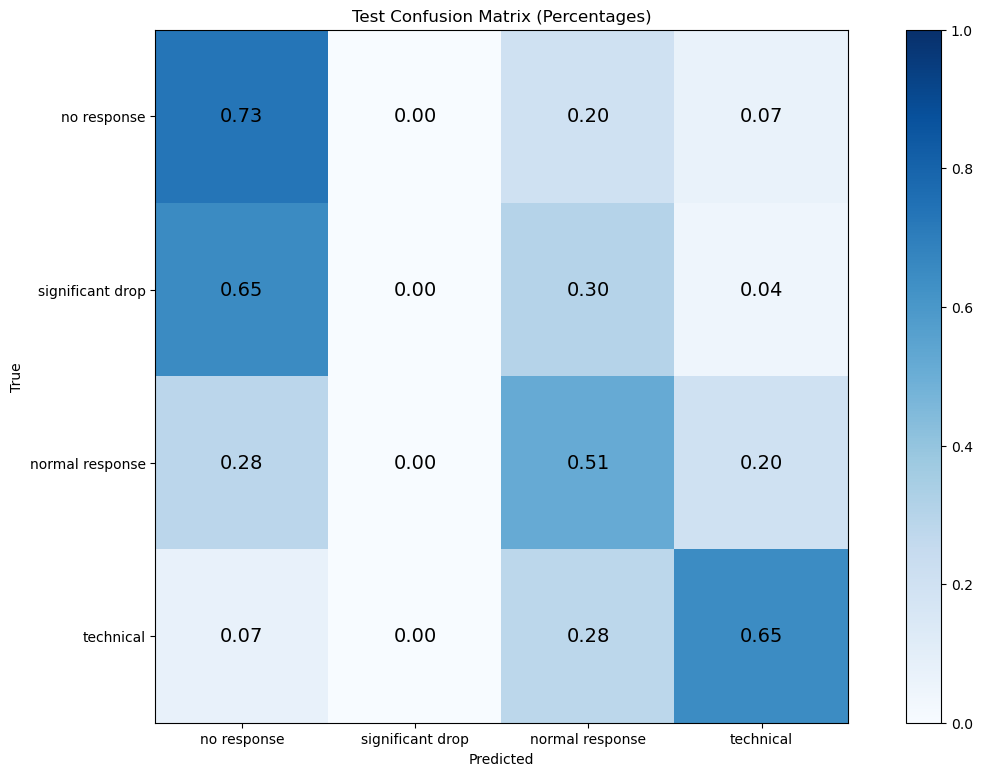

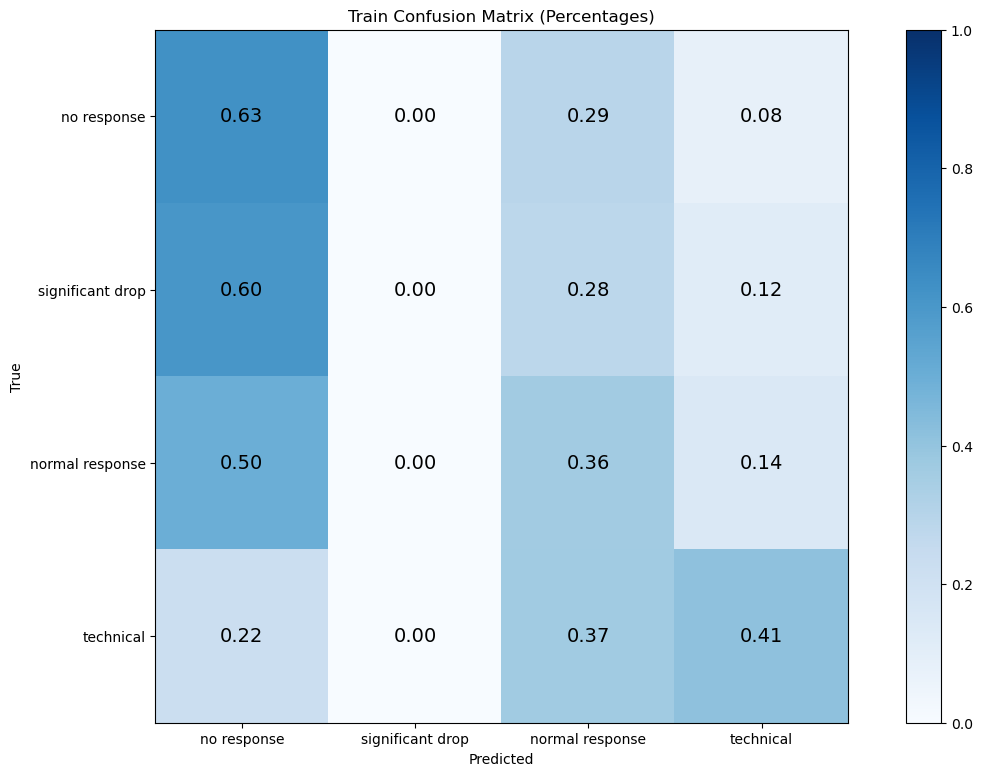

In [ ]:
# Confusion matrix
true_labels = torch.stack(all_labels).cpu().numpy()
pred_labels = torch.stack(all_preds).cpu().numpy()

show_confusion_matrix(true_labels, pred_labels, class_dict, data_type='Test')
show_confusion_matrix(train_true, train_pred, class_dict, data_type='Train')

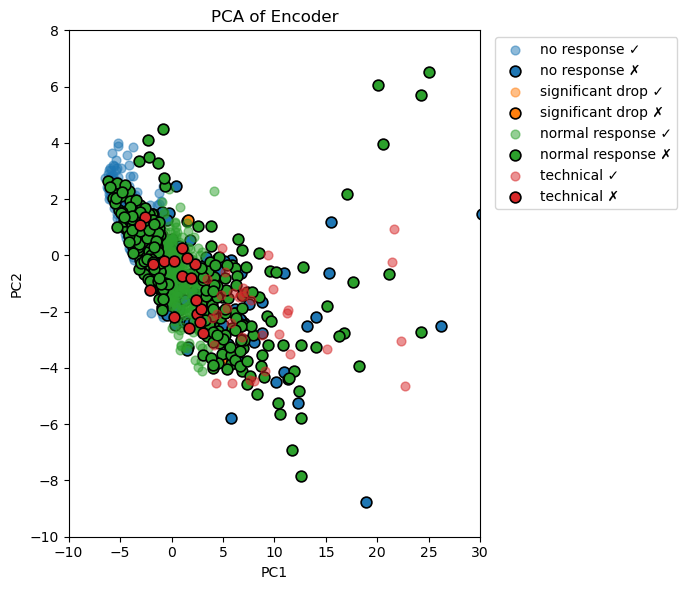

In [ ]:
# Evaluating predictions in order to present PCA
model.eval()
classifier.eval()

all_feats, all_true, all_pred = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        # encode and pool
        z = model.encoder(xb)
        z = F.adaptive_avg_pool1d(z, 1).squeeze(-1)  # (B, latent_dim)
        # classifier prediction
        logits = classifier.classifier(z)
        yhat = logits.argmax(dim=1).cpu()

        all_feats.append(z.cpu())
        all_true.append(yb.cpu())
        all_pred.append(yhat)

# Concatenate
all_feats = torch.cat(all_feats, dim=0).numpy()
all_true  = torch.cat(all_true, dim=0).numpy()
all_pred  = torch.cat(all_pred, dim=0).numpy()

# PCA
X = StandardScaler().fit_transform(all_feats)
pca = PCA(n_components=2, random_state=0)
X2 = pca.fit_transform(X)
expl = pca.explained_variance_ratio_

# Plot by true labels, mark misclassified
label_names = ["no response","significant drop","normal response","technical"]
colors = ["#1f77b4","#ff7f0e","#2ca02c","#d62728"]

plt.figure(figsize=(7,6))
for c, name, color in zip(range(len(label_names)), label_names, colors):
    idx = (all_true == c)
    idx_ok  = idx & (all_true == all_pred)
    idx_bad = idx & (all_true != all_pred)

    # correct points
    plt.scatter(X2[idx_ok,0], X2[idx_ok,1], s=40, c=color, label=f"{name} ✓", alpha=0.5)
    # misclassified points
    if np.any(idx_bad):
        plt.scatter(X2[idx_bad,0], X2[idx_bad,1], s=60, facecolors="none",
                    edgecolors="black", linewidths=1.2, c=color, label=f"{name} ✗")
plt.xlim(-10, 30)
plt.ylim(-10, 8)

plt.title(f"PCA of Encoder")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
# Saving a rotating 3D plot of PCA
X = StandardScaler().fit_transform(all_feats)
pca = PCA(n_components=3, random_state=0)
X3 = pca.fit_transform(X)
label_names = ["no response","significant drop","normal response","technical"]
class_dict = dict(enumerate(label_names))

plot_embeddings_3d_with_rotation(
    embeddings_3d=X3,
    y=all_true,
    class_dict=class_dict,
    graph_title="3D PCA of Encoder",
    density_centroids=None,  # or provide dict if you have them
    output_path="pca_rotation.mp4"
)

Saved rotating 3D plot to: /home/sipl-prj10364/pca_rotation.mp4
